In [ ]:
# Importing necessary libraries
import os
import cv2
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.metrics import AUC,Precision, Recall
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from keras.applications import Xception,VGG19,ResNet50,InceptionResNetV2,ResNet152V2,EfficientNetB2,ConvNeXtTiny
from keras.layers import Dense,GlobalAveragePooling2D,GlobalMaxPooling2D,Dropout
random.seed(555)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the dataset
The casting dataset was chosen for defective product classification due to its direct relevance to real-world challenges in manufacturing. Identifying and classifying defective products is critical for ensuring product quality in industrial processes. The dataset provides an opportunity to contribute to the improvement of manufacturing efficiency and reliability. This classification task is inherently challenging, involving subtle defects and variations in lighting conditions, which enhances the complexity of the problem. The availability of labelled data within the dataset facilitates effective supervised machine learning model development, contributing to the educational value of the project. In summary, the casting dataset aligns with practical applications, addresses a significant industrial problem, and offers a valuable opportunity for skill development and contributions to quality control processes.

In [ ]:
# Import the necessary module for mounting Google Drive in Google Colab
from google.colab import drive

# Mount Google Drive to the '/content/drive' directory
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the directory path for the training data
train_directory = "/content/drive/MyDrive/Datasets/casting_data1/train"

# Define the directory path for the testing data
test_directory = "/content/drive/MyDrive/Datasets/casting_data1/test"

In [ ]:
# Show what the dictories train_directory and test_directory have
import os
import warnings
warnings.filterwarnings('ignore')
print("Train Directory:",os.listdir(train_directory))
print("Test Directory: ", os.listdir(train_directory))

Train Directory: ['ok_front', 'def_front']
Test Directory:  ['ok_front', 'def_front']


In [ ]:
# Define the directory path for the training ok and defected data
train_def_directory = train_directory+'/def_front/'
train_ok_directory = train_directory+'/ok_front/'

# Define the directory path for the testing ok and defected data
test_ok_directory = test_directory+'/ok_front/'
test_def_directory =test_directory+'/def_front/'

In [ ]:
# Showing the count of the contents in training and testing directories
print("Training def data:",len(os.listdir(train_def_directory)))
print("Training ok data:",len(os.listdir(train_ok_directory)))
print("Testing ok data:",len(os.listdir(test_ok_directory)))
print("Testing def data:",len(os.listdir(test_def_directory)))

Training def data: 1500
Training ok data: 1510
Testing ok data: 262
Testing def data: 262


#### Example of defected and ok fronts.

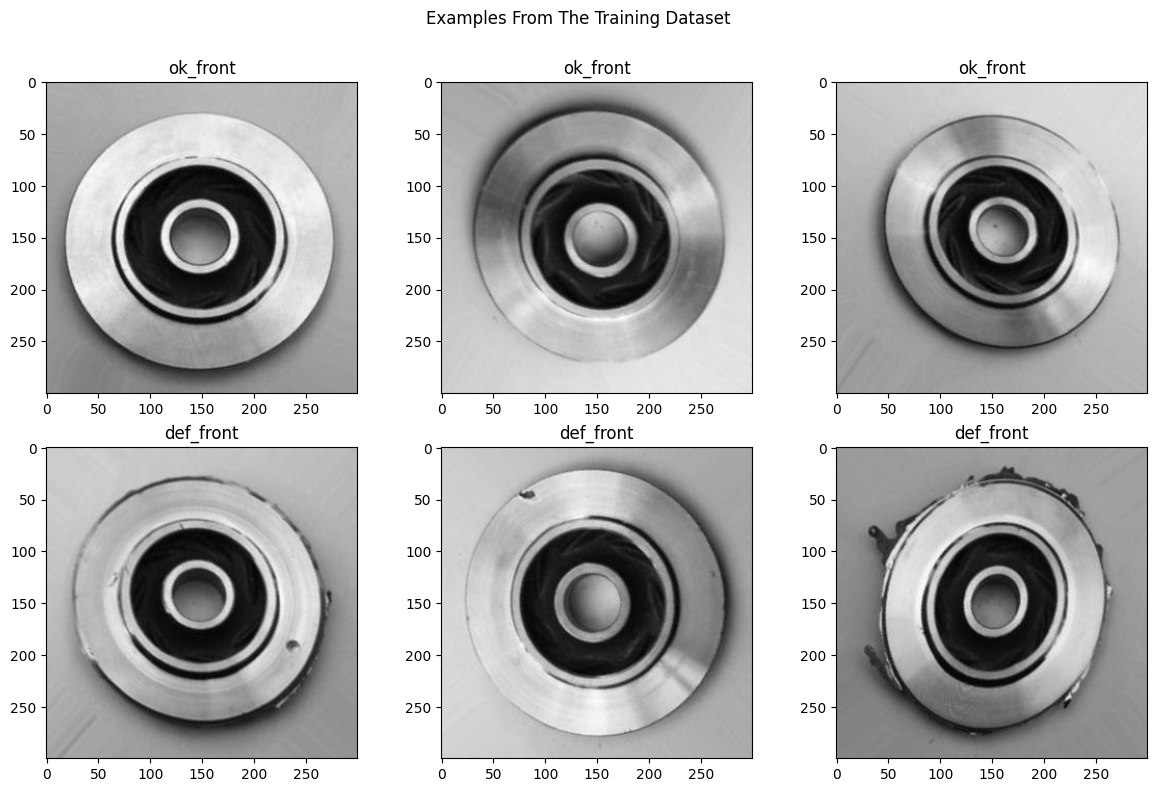

In [ ]:
# Function to display a random selection of image files from a directory
def display_random_image_files(directory, num_files):
    # List all files in the directory
    files = os.listdir(directory)
    # Shuffle the list to get a random order
    random.shuffle(files)
    # Return the first 'num_files' files from the shuffled list
    return files[:num_files]

# Create a 2x3 grid for "ok_front" images
plt.figure(figsize=(12, 8))
plt.suptitle('Examples From The Training Dataset\n')

# Display random "ok_front" images
for i in range(3):
    plt.subplot(2, 3, i + 1)
    image_files_ok = display_random_image_files(train_ok_directory, 3)
    img = Image.open(os.path.join(train_ok_directory, image_files_ok[i]))
    plt.imshow(img)
    plt.title('ok_front')

# Create a 2x3 grid for "def_front" images
for i in range(3):
    plt.subplot(2, 3, i + 4)
    image_files_def = display_random_image_files(train_def_directory, 3)
    img = Image.open(os.path.join(train_def_directory, image_files_def[i]))
    plt.imshow(img)
    plt.title('def_front')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


####Images shape

In [ ]:
try:
    # Attempt to open the image file
    img = Image.open(os.path.join(train_ok_directory, 'cast_ok_0_1.jpeg'))

    # Get image size and mode
    img_size = img.size
    img_mode = img.mode

    # Print image information
    print(f"Image size: {img_size}")
    print(f"Image mode: {img_mode}")

# Handle the case where the file is not found
except FileNotFoundError:
    print("The file or directory does not exist.")


Image size: (300, 300)
Image mode: RGB


### Resizing the images
Standardizing image dimensions by resizing them, ensuring uniformity and compatibility across all images in the dataset.

In [ ]:
# Define the image size for preprocessing
img_size = (300, 300)

# Set a random seed for reproducibility
rand_seed = 555

# Define the batch size for training
batch_size = 32

# Set the number of training epochs
epochs = 15


### Data Augmentation for the training set
Increasing the dataset diversity by applying augmentation techniques. Rotation, setting up a brightness range, and flipping are commonly used to create variations of the original images, helping the model generalize better to different perspectives and orientations

In [ ]:
# Create an ImageDataGenerator for training data
train_datagenerator = ImageDataGenerator(
    rescale=1./255,              # Rescale pixel values to the range [0, 1]
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True,          # Randomly flip images vertically
    rotation_range=40,           # Randomly rotate images in the range [-40, 40] degrees
    brightness_range=[0.2, 1.5],  # Randomly adjust brightness
    validation_split=0.4,        # Specify the validation split (40% of the data)
)

# Create an ImageDataGenerator for testing data
test_datagenerator = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to the range [0, 1]


### Data Splitting
Implementing data splitting to create separate sets for training, validation, and testing. This ensures that the model is trained on one subset, validated on another, and tested on a third, enabling robust evaluation of its performance.

In [ ]:
# Dictionary of arguments for training data generator
arg_train = {
    'target_size': img_size,      # Target size for resizing images
    'color_mode': 'rgb',          # Color mode for images (RGB)
    'classes': {'ok_front': 0, 'def_front': 1},  # Class labels mapping
    'class_mode': 'binary',       # Binary classification (0 or 1)
    'batch_size': batch_size,      # Batch size for training
    'seed': rand_seed             # Random seed for reproducibility
}

# Dictionary of arguments for testing data generator
arg_test = {
    'target_size': img_size,      # Target size for resizing images
    'color_mode': 'rgb',          # Color mode for images (RGB)
    'classes': {'ok_front': 0, 'def_front': 1},  # Class labels mapping
    'class_mode': 'binary',       # Binary classification (0 or 1)
    'batch_size': batch_size,      # Batch size for testing
    'seed': rand_seed,            # Random seed for reproducibility
    'shuffle': False              # Do not shuffle data for testing
}

# 80% of the training data
train_set = train_datagenerator.flow_from_directory(
    directory=train_directory,
    subset='training',
    **arg_train
)

# 20% of the training data for validation
valid_set = train_datagenerator.flow_from_directory(
    directory=train_directory,
    subset='validation',
    **arg_train
)

# Testing data
test_set = test_datagenerator.flow_from_directory(
    directory=test_directory,
    **arg_test
)


Found 1806 images belonging to 2 classes.
Found 1204 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


## Buiding the model


In [ ]:

# Function to load a pre-trained model based on the specified model name
def pretrained_model(model_name):
    if model_name == 'ResNet152V2':
        # Load ResNet152V2 pre-trained model without the top classification layer
        return ResNet152V2(weights='imagenet', include_top=False)
    else:
        # Raise an error for an invalid model name
        raise ValueError(f"Invalid model name: {model_name}")


# Function to create and compile a new model based on a pre-trained base model
def create_model(base_model, learning_rate=0.01):
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer='l1_l2')(x)
    x = Dense(128, activation='relu', kernel_regularizer='l1_l2')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Changed the number of output neurons and activation

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=learning_rate),  # Updated optimizer
                  loss='binary_crossentropy',  # Changed the loss function
                  metrics=['accuracy', AUC(), Precision(), Recall()])  # Updated metrics

    return model

model_checkpoint = ModelCheckpoint( # Define a ModelCheckpoint callback to save the best model based on validation AUC
        filepath='best_model.h5',
        monitor='val_auc',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )
# Function to train and evaluate the model with specified datasets
def model_training(model, model_name, train_set, valid_set, test_set, epochs=10, batch_size=32):
    global model_checkpoint

    # Start the timer
    start_time = time.time()

    history = model.fit(
        train_set,
        steps_per_epoch=train_set.samples // batch_size,
        epochs=epochs,
        validation_data=valid_set,
        validation_steps=valid_set.samples // batch_size,
        callbacks=[model_checkpoint]
    )

    # End the timer
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model on the test set
    test_loss, *test_metrics = model.evaluate(test_set, steps=test_set.samples // batch_size)
    test_acc = test_metrics[0]
    test_auc = test_metrics[1]
    test_precision = test_metrics[2]
    test_recall = test_metrics[3]

    # Start the evaluation timer
    evaluation_time = time.time() - end_time

    # Print the results
    print(f"model: {model_name}")
    print(f"Test accuracy: {test_acc * 100:.2f}%")
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Evaluation time: {evaluation_time:.2f} seconds")

    y_true = test_set.classes
    y_pred = model.predict(test_set)
    y_pred_classes = (y_pred > 0.5).astype(int)  # Convert to 0 or 1 based on a threshold
    cm = confusion_matrix(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes)
    auc = roc_auc_score(y_true, y_pred)

    return test_acc, cm, report, auc, test_precision, test_recall, history.history


## Train the model

Here the functions defined above are called to train and evaluate the model.

In [ ]:
%%time

model_names = ['ResNet152V2']
results = {}

for model_name in model_names:
    print(f"Training model: {model_name}")

    # Load pre-trained model
    base_model = pretrained_model(model_name)

    # Create and compile a new model based on the pre-trained model
    model = create_model(base_model)

    # Train and evaluate the model, storing the results
    test_acc, cm, report, auc, precision, recall, history = model_training(
        model,
        model_name,
        train_set,
        valid_set,
        test_set,
        epochs,
        batch_size
    )

    results[model_name] = {
        'test_accuracy': test_acc,
        'confusion_matrix': cm,
        'classification_report': report,
        'roc_auc': auc,
        'history': history
    }


Training model: ResNet152V2
234545216/234545216 [==============================] - 12s 0us/step
Epoch 1/15
56/56 [==============================] - ETA: 0s - loss: 59.1812 - accuracy: 0.6849 - auc: 0.6656 - precision: 0.6807 - recall: 0.6953
Epoch 1: val_auc improved from -inf to 0.98206, saving model to best_model.h5
56/56 [==============================] - 986s 17s/step - loss: 59.1812 - accuracy: 0.6849 - auc: 0.6656 - precision: 0.6807 - recall: 0.6953 - val_loss: 16.5370 - val_accuracy: 0.9147 - val_auc: 0.9821 - val_precision: 0.8849 - val_recall: 0.9525
Epoch 2/15
56/56 [==============================] - ETA: 0s - loss: 12.1754 - accuracy: 0.8523 - auc: 0.9172 - precision: 0.8616 - recall: 0.8382
Epoch 2: val_auc did not improve from 0.98206
56/56 [==============================] - 103s 2s/step - loss: 12.1754 - accuracy: 0.8523 - auc: 0.9172 - precision: 0.8616 - recall: 0.8382 - val_loss: 10.5530 - val_accuracy: 0.9215 - val_auc: 0.9790 - val_precision: 0.9510 - val_recall: 0.

####Results and Metrics

Best Model: ResNet152V2
Test Accuracy: 97.66%
Confusion Matrix:
[[255   7]
 [  5 257]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       262
           1       0.97      0.98      0.98       262

    accuracy                           0.98       524
   macro avg       0.98      0.98      0.98       524
weighted avg       0.98      0.98      0.98       524

ROC AUC: 1.00


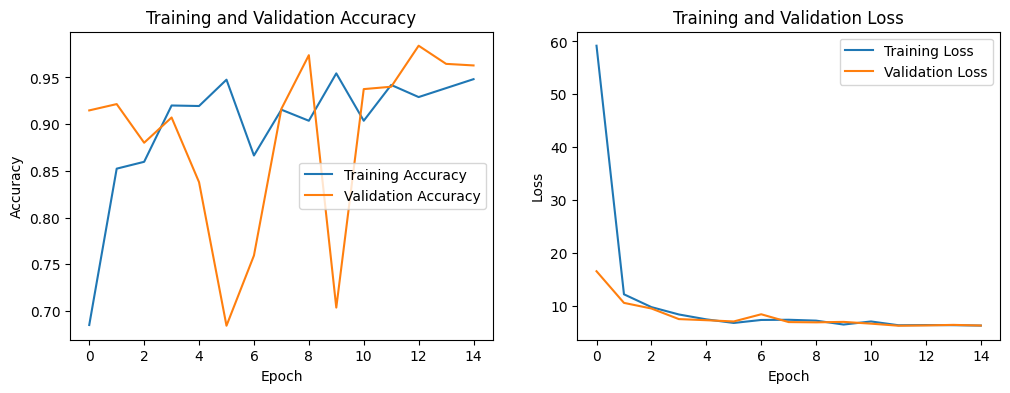

In [ ]:
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model_results = results[best_model_name]

# Access the performance metrics
best_test_acc = best_model_results['test_accuracy']
best_cm = best_model_results['confusion_matrix']
best_report = best_model_results['classification_report']
best_auc = best_model_results['roc_auc']
best_history = best_model_results['history']

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {best_test_acc * 100:.2f}%")
print("Confusion Matrix:")
print(best_cm)
print("Classification Report:")
print(best_report)
print(f"ROC AUC: {best_auc:.2f}")

# Plot training and validation accuracy and loss

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_history['accuracy'], label='Training Accuracy')
plt.plot(best_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Load the saved model
best_model = load_model("/content/best_model.h5")
# The 'test_set' is set up as mentioned earlier
predictions = best_model.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
true_labels = test_set.classes

# Calculate classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
conf_matrix = confusion_matrix(true_labels, predicted_labels)

17/17 [==============================] - 9s 417ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       262
           1       1.00      0.96      0.98       262

    accuracy                           0.98       524
   macro avg       0.98      0.98      0.98       524
weighted avg       0.98      0.98      0.98       524



## Fine Tuning
Here, the last few layers of a pre-trained model are trained on a new dataset. The idea is to leverage the knowledge gained by the pre-trained model on a large dataset and adapt it to a specific task.

The fine_tune_model function is added, taking the existing model, the pre-trained base model, and the number of layers to fine-tune. The function allows the specified number of layers from the end of the base model to be trainable and then recompiles the model with a lower learning rate for fine-tuning. Finally, it fine-tunes the model using the same training process.

In [ ]:
fine_tune_model_checkpoint = ModelCheckpoint(
    filepath='best_fine_tuned_model.h5',
    monitor='val_auc_3',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [ ]:
def fine_tune_model(model, base_model, fine_tune_layers=10, learning_rate=0.0001):
    """
    Fine-tune the model by training the last few layers of the base model.

    Parameters:
    - model: The model to fine-tune.
    - base_model: The pre-trained base model.
    - fine_tune_layers: Number of layers to fine-tune.
    - learning_rate: Learning rate for the optimizer.

    Returns:
    - Fine-tuned model.
    """
    global fine_tune_model_checkpoint

    # Allow the specified number of layers to be trainable
    for layer in base_model.layers[-fine_tune_layers:]:
        layer.trainable = True

    # Recompile the model with a lower learning rate for fine-tuning
    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(), Precision(), Recall()])

    # Fine-tune the model
    history_fine_tune = model.fit(
        train_set,
        steps_per_epoch=train_set.samples // batch_size,
        epochs=epochs,
        validation_data=valid_set,
        validation_steps=valid_set.samples // batch_size,
        callbacks=[fine_tune_model_checkpoint]
    )

    return model, history_fine_tune

# Fine-tune the model
model, history_fine_tune = fine_tune_model(model, base_model, fine_tune_layers=10, learning_rate=0.0001)

Epoch 1/15
56/56 [==============================] - ETA: 0s - loss: 0.4198 - accuracy: 0.9814 - auc_3: 0.9943 - precision_3: 0.9841 - recall_3: 0.9785
Epoch 1: val_auc_3 improved from -inf to 0.99930, saving model to best_fine_tuned_model.h5
56/56 [==============================] - 208s 3s/step - loss: 0.4198 - accuracy: 0.9814 - auc_3: 0.9943 - precision_3: 0.9841 - recall_3: 0.9785 - val_loss: 0.3541 - val_accuracy: 0.9907 - val_auc_3: 0.9993 - val_precision_3: 0.9866 - val_recall_3: 0.9949
Epoch 2/15
56/56 [==============================] - ETA: 0s - loss: 0.3468 - accuracy: 0.9870 - auc_3: 0.9945 - precision_3: 0.9909 - recall_3: 0.9831
Epoch 2: val_auc_3 did not improve from 0.99930
56/56 [==============================] - 101s 2s/step - loss: 0.3468 - accuracy: 0.9870 - auc_3: 0.9945 - precision_3: 0.9909 - recall_3: 0.9831 - val_loss: 0.3141 - val_accuracy: 0.9941 - val_auc_3: 0.9987 - val_precision_3: 0.9966 - val_recall_3: 0.9915
Epoch 3/15
56/56 [=============================

In [ ]:
# Load the saved model
tuned_model = load_model("/content/best_fine_tuned_model.h5")
# The 'test_set' is set up as mentioned earlier
predictions = tuned_model.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
true_labels = test_set.classes

# Calculate classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
conf_matrix = confusion_matrix(true_labels, predicted_labels)

17/17 [==============================] - 10s 401ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       262
           1       1.00      1.00      1.00       262

    accuracy                           1.00       524
   macro avg       1.00      1.00      1.00       524
weighted avg       1.00      1.00      1.00       524

